<a href="https://colab.research.google.com/github/manasvigarg03/RNN_LSTM_CropPrediction/blob/main/Crop_temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv(f'/content/drive/MyDrive/hyderabad.csv')

In [ ]:
df.head()


,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2009-01-01 00:00:00,28,15,0.0,8.7,6,1,31,09:57 AM,09:58 PM,...,21,9,0,83,0.0,1013,16,10,150,6
1,2009-01-01 01:00:00,28,15,0.0,8.7,6,1,31,09:57 AM,09:58 PM,...,20,9,0,85,0.0,1013,16,10,148,5
2,2009-01-01 02:00:00,28,15,0.0,8.7,6,1,31,09:57 AM,09:58 PM,...,20,8,0,86,0.0,1013,15,10,147,5
3,2009-01-01 03:00:00,28,15,0.0,8.7,6,1,31,09:57 AM,09:58 PM,...,19,8,0,88,0.0,1013,15,10,145,5
4,2009-01-01 04:00:00,28,15,0.0,8.7,6,1,31,09:57 AM,09:58 PM,...,21,7,0,80,0.0,1014,16,10,148,5


In [ ]:
features = ['maxtempC', 'mintempC', 'sunHour', 'humidity', 'precipMM' , 'pressure','tempC', 'windspeedKmph']
target = 'tempC'

In [ ]:
X = df[features].values
y = df[target].values.reshape(-1, 1)

In [ ]:
X

array([[  28. ,   15. ,    8.7, ..., 1013. ,   16. ,    6. ],
       [  28. ,   15. ,    8.7, ..., 1013. ,   16. ,    5. ],
       [  28. ,   15. ,    8.7, ..., 1013. ,   15. ,    5. ],
       ...,
       [  26. ,   18. ,    4.2, ..., 1016. ,   21. ,   15. ],
       [  26. ,   18. ,    4.2, ..., 1016. ,   21. ,   16. ],
       [  26. ,   18. ,    4.2, ..., 1016. ,   20. ,   17. ]])

In [ ]:
y


array([[16],
       [16],
       [15],
       ...,
       [21],
       [21],
       [20]])

In [ ]:
df[features].head()

,maxtempC,mintempC,sunHour,humidity,precipMM,pressure,tempC,windspeedKmph
0,28,15,8.7,83,0.0,1013,16,6
1,28,15,8.7,85,0.0,1013,16,5
2,28,15,8.7,86,0.0,1013,15,5
3,28,15,8.7,88,0.0,1013,15,5
4,28,15,8.7,80,0.0,1014,16,5


In [ ]:
df = df.dropna(subset=["tempC"])
df=df.reset_index(drop=True)
training_set = df.iloc[::24,21:22].values

In [ ]:
training_set

array([[16],
       [17],
       [17],
       ...,
       [19],
       [20],
       [19]])

In [ ]:
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
X = []
y = []
n_future = 45 # next 45 days temperature forecast
n_past = 45  # Past 45 days
for i in range(0,len(training_set_scaled)-n_past-n_future+1):
    X.append(training_set_scaled[i : i + n_past , 0])
    y.append(training_set_scaled[i + n_past : i + n_past + n_future , 0 ])
X , y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0] , X.shape[1], 1) )

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM,Dense ,Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

In [ ]:
from tensorflow.keras.layers import Bidirectional



regressor = Sequential()
regressor.add(Bidirectional(LSTM(units=15, return_sequences=True, input_shape = (X_train.shape[1],1) ) ))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units= 15 , return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units= 15))
regressor.add(Dropout(0.3))
regressor.add(Dense(units = n_future,activation='linear'))
regressor.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc'])
history = regressor.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_split=0.1, shuffle = False,callbacks=[early_stopping]
                        )

Epoch 1/20
89/89 [==============================] - 20s 71ms/step - loss: 0.1346 - acc: 0.0205 - val_loss: 0.0292 - val_acc: 0.0127
Epoch 2/20
89/89 [==============================] - 6s 65ms/step - loss: 0.0416 - acc: 0.0272 - val_loss: 0.0167 - val_acc: 0.0190
Epoch 3/20
89/89 [==============================] - 4s 47ms/step - loss: 0.0301 - acc: 0.0248 - val_loss: 0.0121 - val_acc: 0.0508
Epoch 4/20
89/89 [==============================] - 5s 52ms/step - loss: 0.0252 - acc: 0.0304 - val_loss: 0.0116 - val_acc: 0.0444
Epoch 5/20
89/89 [==============================] - 5s 59ms/step - loss: 0.0224 - acc: 0.0265 - val_loss: 0.0137 - val_acc: 0.0317
Epoch 6/20
89/89 [==============================] - 4s 47ms/step - loss: 0.0205 - acc: 0.0269 - val_loss: 0.0102 - val_acc: 0.0349
Epoch 7/20
89/89 [==============================] - 5s 56ms/step - loss: 0.0189 - acc: 0.0272 - val_loss: 0.0092 - val_acc: 0.0317
Epoch 8/20
89/89 [==============================] - 5s 58ms/step - loss: 0.0172 - 

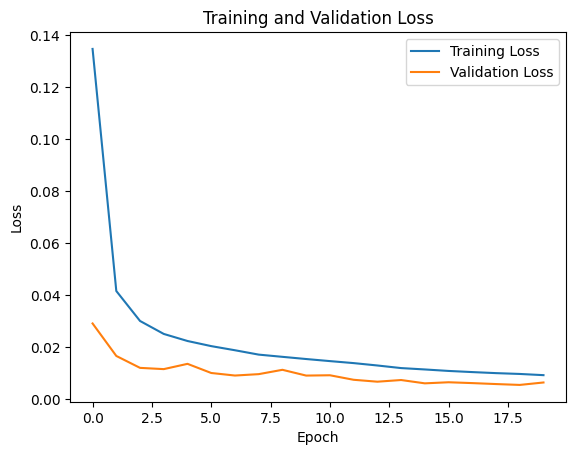

In [ ]:
import matplotlib.pyplot as plt


# Plot training loss vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

predicted_temperature = regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predicted_temperature))
print("RMSE:", rmse)

25/25 [==============================] - 3s 22ms/step
RMSE: 0.10435470218495453


In [ ]:
predicted_temperature = sc.inverse_transform(predicted_temperature)
y_test = sc.inverse_transform(y_test)

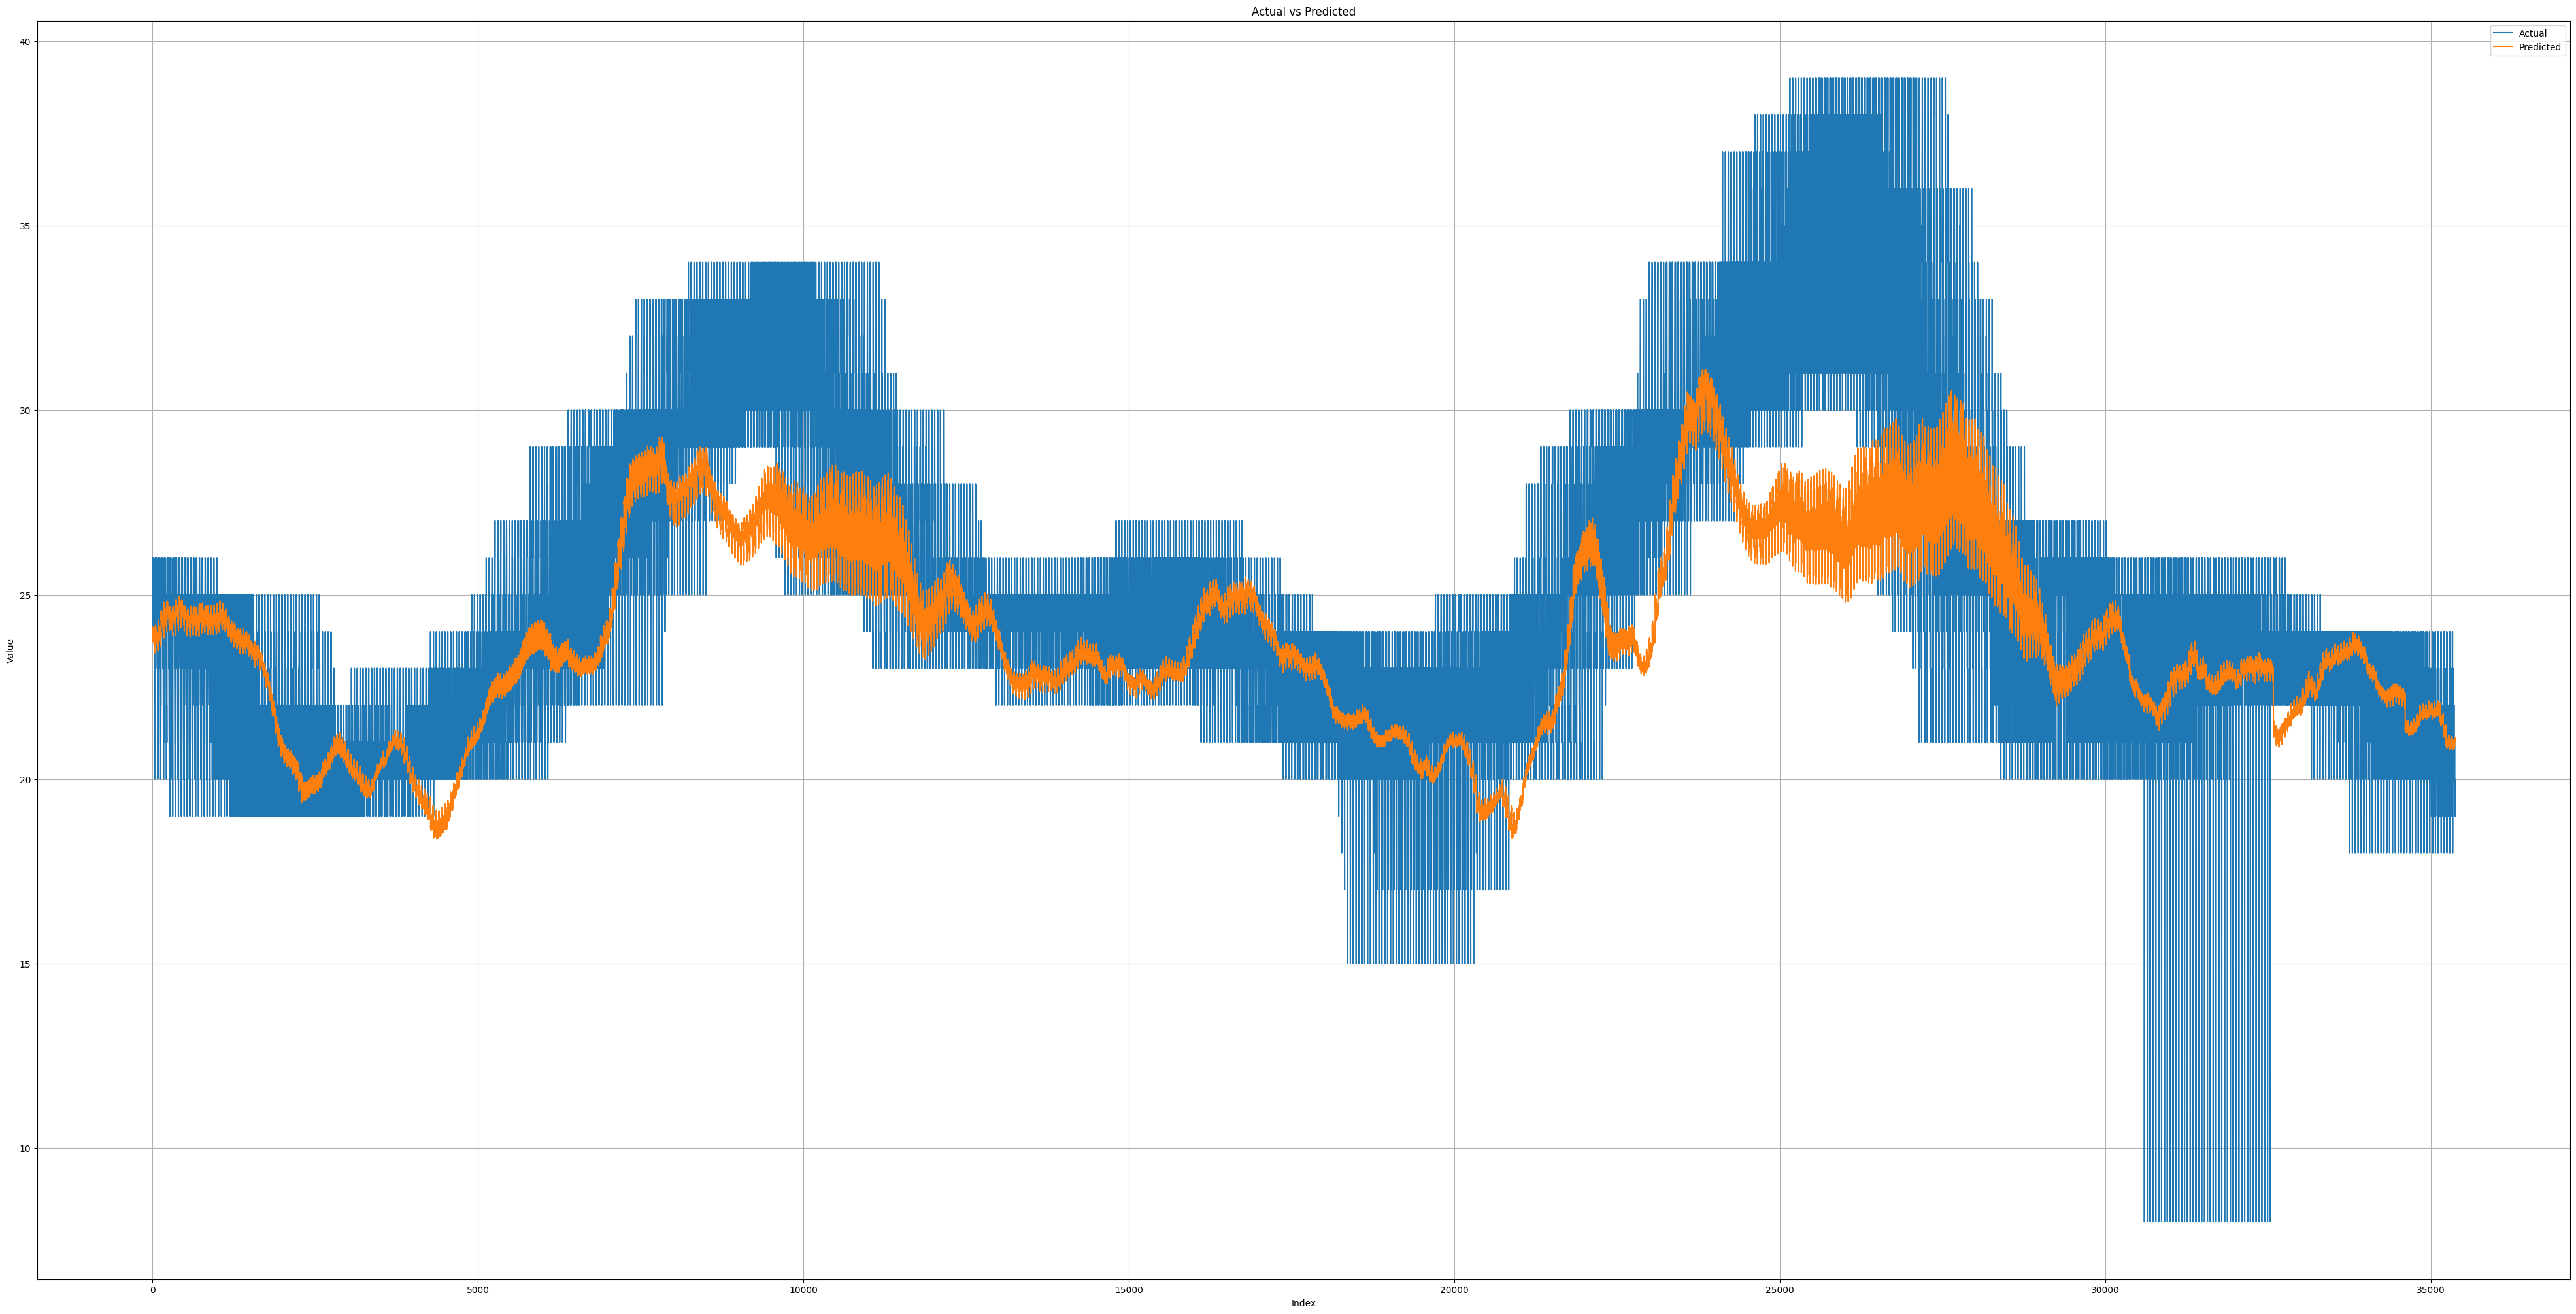

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_test contains the true target values and y_pred contains the predicted target values
plt.figure(figsize=(50, 25))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(predicted_temperature.flatten(), label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()